# Question and Answer Bahasa Indonesia dengan RNN

##Pendahuluan

Proyek ini bertujuan untuk membangun sistem Question and Answer (QA) menggunakan model Recurrent Neural Network (RNN) dengan arsitektur SimpleRNN untuk bahasa Indonesia. Sistem ini akan dilatih untuk memahami konteks teks dan menemukan jawaban yang relevan dari konteks tersebut berdasarkan pertanyaan yang diberikan. Fokus utama adalah pada dataset IndoQA, dengan implementasi langkah-langkah preprocessing data, pembangunan model SimpleRNN, serta evaluasi performa model untuk tugas QA berbasis ekstrak.

## Instalasi, Impor Library, dan Memuat Dataset

Pada bagian ini kami menginstal library yang dibutuhkan, mengimpor library tersebut ke dalam notebook, dan memuat dataset IndoQA dari Hugging Face.

In [1]:
# Instalasi library yang dibutuhkan
!pip install datasets==2.19.1 tensorflow numpy

# Impor library
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset
import numpy as np
import json

# Memuat dataset dari Hugging Face
try:
    dataset = load_dataset("jakartaresearch/indoqa")
except Exception as e:
    print(f"Gagal memuat dataset. Error: {e}")
    # Fallback jika ada masalah koneksi, dengan membuat dummy dataset
    data_files = {
        "train": "https://huggingface.co/datasets/jakartaresearch/indoqa/resolve/main/data/train.json",
        "validation": "https://huggingface.co/datasets/jakartaresearch/indoqa/resolve/main/data/validation.json"
    }
    dataset = load_dataset("json", data_files=data_files)


# Menampilkan informasi dasar tentang dataset
print("Struktur Dataset:")
print(dataset)

# Menampilkan satu contoh data dari split 'train'
print("\nContoh Data:")
print(json.dumps(dataset['train'][0], indent=2, ensure_ascii=False))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.3.1 which is incompatible.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3309 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1104 [00:00<?, ? examples/s]

Struktur Dataset:
DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answer', 'category', 'span_start', 'span_end'],
        num_rows: 3309
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answer', 'category', 'span_start', 'span_end'],
        num_rows: 1104
    })
})

Contoh Data:
{
  "id": "629HsNl5Qf3THUq_CbmFrSx28",
  "context": "Para pemuda pejuang, termasuk Chaerul Saleh, Sukarni, dan Wikana yang terbakar gelora kepahlawanannya setelah berdiskusi dengan Ibrahim gelar Datuk Tan Malaka. Pada dini hari tanggal 16 Agustus 1945, mereka bersama Shodanco Singgih, salah seorang anggota PETA, dan pemuda lain, membawa Soekarno (bersama Fatmawati dan Guntur yang baru berusia 9 bulan) serta Hatta, ke Rengasdengklok, yang kemudian terkenal sebagai Peristiwa Rengasdengklok. Tujuannya adalah agar Soekarno dan Hatta tidak terpengaruh oleh Jepang. Di sini, mereka kembali meyakinkan Soekarno bahwa Jepang telah menyerah dan para pej

## Validasi dan Pembersihan Data Awal

Tujuan dari sel ini adalah untuk memastikan setiap baris data yang akan kita gunakan adalah valid. Kita akan melakukan dua pengecekan krusial:
- Memastikan bahwa `span_start` dan `span_end` yang diberikan benar-benar menghasilkan teks `answer` jika kita potong (slice) dari `context`.
- Menghapus data di mana `span_start` adalah -1, yang menandakan jawaban tidak dapat ditemukan di dalam `context`.

Dengan melakukan ini di awal, kita memastikan bahwa semua data yang lolos ke tahap tokenisasi adalah data yang "bersih" dan berkualitas.

In [2]:
import pandas as pd

def validate_and_clean_data(dataset_split):
    """
    Fungsi untuk memvalidasi dan membersihkan data.
    - Memastikan span start & end cocok dengan answer.
    - Menghapus data dengan span_start = -1.
    """
    # Konversi ke pandas DataFrame untuk kemudahan manipulasi
    df = pd.DataFrame(dataset_split)

    # Filter 1: Hapus data yang tidak memiliki jawaban (span_start == -1)
    initial_rows = len(df)
    df = df[df['span_start'] != -1].copy()
    rows_after_filter1 = len(df)
    print(f"Filter 1: Menghapus data tanpa jawaban. Ditemukan dan dihapus: {initial_rows - rows_after_filter1} baris.")

    # Filter 2: Verifikasi kecocokan span dengan jawaban
    def verify_span(row):
        # Ambil teks jawaban berdasarkan span dari konteks
        extracted_text = row['context'][row['span_start']:row['span_end']]
        # Bandingkan dengan teks jawaban asli (setelah normalisasi spasi)
        return " ".join(extracted_text.split()) == " ".join(row['answer'].split())

    is_valid_span = df.apply(verify_span, axis=1)

    rows_before_filter2 = len(df)
    df = df[is_valid_span]
    rows_after_filter2 = len(df)
    print(f"Filter 2: Memverifikasi span karakter. Ditemukan dan dihapus data yang tidak cocok: {rows_before_filter2 - rows_after_filter2} baris.")

    # Konversi kembali ke format list of dictionaries
    cleaned_data = df.to_dict(orient='records')
    return cleaned_data

# Jalankan pembersihan pada data training dan validasi
print("--- Memvalidasi Training Data ---")
cleaned_train_data = validate_and_clean_data(dataset['train'])
print(f"Jumlah data training setelah dibersihkan: {len(cleaned_train_data)}")

print("\n--- Memvalidasi Validation Data ---")
cleaned_val_data = validate_and_clean_data(dataset['validation'])
print(f"Jumlah data validasi setelah dibersihkan: {len(cleaned_val_data)}")

# -- Pengecekan Hasil --
print("\n--- Pengecekan Hasil Pembersihan ---")
# Cek apakah masih ada data setelah dibersihkan
if cleaned_train_data and cleaned_val_data:
    print("Pembersihan data berhasil.")
    print("Contoh data pertama setelah dibersihkan:")
    print(json.dumps(cleaned_train_data[0], indent=2, ensure_ascii=False))
else:
    print("Peringatan: Tidak ada data yang tersisa setelah pembersihan!")

--- Memvalidasi Training Data ---
Filter 1: Menghapus data tanpa jawaban. Ditemukan dan dihapus: 60 baris.
Filter 2: Memverifikasi span karakter. Ditemukan dan dihapus data yang tidak cocok: 174 baris.
Jumlah data training setelah dibersihkan: 3075

--- Memvalidasi Validation Data ---
Filter 1: Menghapus data tanpa jawaban. Ditemukan dan dihapus: 20 baris.
Filter 2: Memverifikasi span karakter. Ditemukan dan dihapus data yang tidak cocok: 45 baris.
Jumlah data validasi setelah dibersihkan: 1039

--- Pengecekan Hasil Pembersihan ---
Pembersihan data berhasil.
Contoh data pertama setelah dibersihkan:
{
  "id": "629HsNl5Qf3THUq_CbmFrSx28",
  "context": "Para pemuda pejuang, termasuk Chaerul Saleh, Sukarni, dan Wikana yang terbakar gelora kepahlawanannya setelah berdiskusi dengan Ibrahim gelar Datuk Tan Malaka. Pada dini hari tanggal 16 Agustus 1945, mereka bersama Shodanco Singgih, salah seorang anggota PETA, dan pemuda lain, membawa Soekarno (bersama Fatmawati dan Guntur yang baru berusi

## Membangun Kosakata dengan Tokenizer

Di sel ini, tugas kita fokus pada satu hal: menganalisis semua teks yang bersih dan membuat kamus kata-ke-angka. Kita akan menggunakan `Tokenizer` dari `Keras` untuk melakukan ini secara otomatis. Proses ini akan menjadi dasar untuk mengubah semua teks kita menjadi sekuens numerik di sel berikutnya.

In [3]:
# -- Hyperparameters untuk Tokenisasi --
VOCAB_SIZE = 10000  # Ukuran kosakata (jumlah kata unik yang akan dipertimbangkan)
OOV_TOKEN = "<unk>" # Token untuk kata-kata di luar kosakata (Out-of-Vocabulary)

# 1. Kumpulkan semua teks dari data yang sudah bersih
# Kita hanya perlu teks dari 'context' dan 'question'
all_texts = [d['context'] for d in cleaned_train_data] + \
            [d['question'] for d in cleaned_train_data] + \
            [d['context'] for d in cleaned_val_data] + \
            [d['question'] for d in cleaned_val_data]

# 2. Inisialisasi dan "fit" tokenizer pada semua teks
# Proses ini akan membangun indeks kata (word_index)
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(all_texts)

# -- Pengecekan Hasil --
word_count = len(tokenizer.word_index)
print(f"Tokenizer berhasil dibuat.")
print(f"Total kata unik yang ditemukan: {word_count}")
print(f"Ukuran kosakata yang akan digunakan (VOCAB_SIZE): {VOCAB_SIZE}")

# Tampilkan beberapa kata yang paling umum
print("\nContoh 10 kata paling umum:")
# word_counts adalah dictionary {kata: frekuensi}
# Kita urutkan berdasarkan frekuensi dan ambil 10 teratas
top_10_words = sorted(tokenizer.word_counts.items(), key=lambda item: item[1], reverse=True)[:10]
for word, count in top_10_words:
    print(f"- {word}: {count} kali")

# Tampilkan indeks untuk beberapa kata kunci
print("\nContoh indeks kata:")
print(f"Indeks untuk kata 'indonesia': {tokenizer.word_index.get('indonesia')}")
print(f"Indeks untuk kata 'siapa': {tokenizer.word_index.get('siapa')}")
print(f"Indeks untuk OOV token '<unk>': {tokenizer.word_index.get(OOV_TOKEN)}")

Tokenizer berhasil dibuat.
Total kata unik yang ditemukan: 15031
Ukuran kosakata yang akan digunakan (VOCAB_SIZE): 10000

Contoh 10 kata paling umum:
- dan: 11450 kali
- yang: 11048 kali
- di: 8611 kali
- pada: 6423 kali
- dari: 4259 kali
- dengan: 4027 kali
- untuk: 2985 kali
- dalam: 2875 kali
- tahun: 2823 kali
- ini: 2799 kali

Contoh indeks kata:
Indeks untuk kata 'indonesia': 12
Indeks untuk kata 'siapa': 140
Indeks untuk OOV token '<unk>': 1


## Tokenisasi, Konversi Span, dan Padding

Di sel ini, kita akan melakukan tiga tugas utama:
- Tokenisasi: Mengubah setiap kalimat (konteks dan pertanyaan) dari data yang sudah bersih menjadi urutan angka (integer) menggunakan tokenizer yang sudah kita buat.
- Konversi Span: Mengonversi posisi awal dan akhir jawaban dari indeks karakter menjadi indeks token. Ini adalah langkah yang paling krusial. Kita akan melakukannya dengan cara mencari sub-sekuens token jawaban di dalam sekuens token konteks.
- Padding: Menyamakan panjang semua urutan agar dapat diproses sebagai satu batch oleh model.

In [4]:
# -- Hyperparameters untuk Padding --
MAX_LEN_CONTEXT = 256 # Panjang maksimum untuk konteks setelah di-padding
MAX_LEN_QUESTION = 32 # Panjang maksimum untuk pertanyaan setelah di-padding

def process_data(data_split, tokenizer):
    """
    Fungsi untuk melakukan tokenisasi, konversi span, dan padding.
    """
    contexts_tokenized = []
    questions_tokenized = []
    start_token_labels = []
    end_token_labels = []
    skipped_count = 0

    for item in data_split:
        context = item['context']
        question = item['question']
        answer = item['answer']

        # Tokenisasi konteks, pertanyaan, dan jawaban
        context_tokens = tokenizer.texts_to_sequences([context])[0]
        question_tokens = tokenizer.texts_to_sequences([question])[0]
        answer_tokens = tokenizer.texts_to_sequences([answer])[0]

        # Cari posisi sub-sekuens answer_tokens di dalam context_tokens
        start_token_idx = -1
        end_token_idx = -1

        # Lakukan pencarian sub-list
        for i in range(len(context_tokens) - len(answer_tokens) + 1):
            if context_tokens[i : i + len(answer_tokens)] == answer_tokens:
                start_token_idx = i
                end_token_idx = i + len(answer_tokens) - 1
                break

        # Hanya proses data jika jawaban ditemukan dan tidak melebihi max length
        if start_token_idx != -1 and end_token_idx < MAX_LEN_CONTEXT:
            contexts_tokenized.append(context_tokens)
            questions_tokenized.append(question_tokens)
            start_token_labels.append(start_token_idx)
            end_token_labels.append(end_token_idx)
        else:
            skipped_count += 1

    print(f"Total data yang dilewati (skipped) karena token jawaban tidak cocok: {skipped_count}")

    # Lakukan padding pada hasil
    contexts_padded = pad_sequences(contexts_tokenized, maxlen=MAX_LEN_CONTEXT, padding='post', truncating='post')
    questions_padded = pad_sequences(questions_tokenized, maxlen=MAX_LEN_QUESTION, padding='post', truncating='post')

    # Konversi label menjadi numpy array
    start_labels_np = np.array(start_token_labels)
    end_labels_np = np.array(end_token_labels)

    return contexts_padded, questions_padded, start_labels_np, end_labels_np

# Jalankan fungsi untuk training dan validation set
print("--- Memproses Training Data ---")
train_contexts, train_questions, train_starts, train_ends = process_data(cleaned_train_data, tokenizer)

print("\n--- Memproses Validation Data ---")
val_contexts, val_questions, val_starts, val_ends = process_data(cleaned_val_data, tokenizer)

# -- Pengecekan Hasil --
print("\n--- Pengecekan Hasil Akhir Preprocessing ---")
print(f"Shape of train_contexts: {train_contexts.shape}")
print(f"Shape of train_questions: {train_questions.shape}")
print(f"Shape of train_starts: {train_starts.shape}")
print(f"Shape of train_ends: {train_ends.shape}")

print(f"\nShape of val_contexts: {val_contexts.shape}")
print(f"Shape of val_questions: {val_questions.shape}")
print(f"Shape of val_starts: {val_starts.shape}")
print(f"Shape of val_ends: {val_ends.shape}")

# Verifikasi manual untuk satu sampel
print("\n--- Verifikasi Sampel Pertama Training Data ---")
# Ambil data pertama yang sudah diproses
sample_context_tokens = train_contexts[0]
sample_start_token = train_starts[0]
sample_end_token = train_ends[0]

# Ambil sekuens token jawaban dari konteks
answer_tokens_from_context = sample_context_tokens[sample_start_token : sample_end_token + 1]

# Ubah token kembali menjadi teks
reconstructed_answer = tokenizer.sequences_to_texts([answer_tokens_from_context])[0]

print(f"Konteks (token): \n{sample_context_tokens[:20]}...") # Tampilkan 20 token pertama
print(f"Pertanyaan (token): \n{train_questions[0][:20]}...")
print(f"\nIndex Token Awal (Label): {sample_start_token}")
print(f"Index Token Akhir (Label): {sample_end_token}")
print("\nJawaban asli dari dataset:", cleaned_train_data[0]['answer'])
print("Jawaban yang direkonstruksi dari token:", reconstructed_answer)

--- Memproses Training Data ---
Total data yang dilewati (skipped) karena token jawaban tidak cocok: 8

--- Memproses Validation Data ---
Total data yang dilewati (skipped) karena token jawaban tidak cocok: 1

--- Pengecekan Hasil Akhir Preprocessing ---
Shape of train_contexts: (3067, 256)
Shape of train_questions: (3067, 32)
Shape of train_starts: (3067,)
Shape of train_ends: (3067,)

Shape of val_contexts: (1038, 256)
Shape of val_questions: (1038, 32)
Shape of val_starts: (1038,)
Shape of val_ends: (1038,)

--- Verifikasi Sampel Pertama Training Data ---
Konteks (token): 
[  55  844 2836  151 5166 1705 8045    2 3272    3    1 3273    1   26
 8046    7 1537  577 3434 2723]...
Pertanyaan (token): 
[   7  140 5166 1705 8045 3272    2   55  844 2836 8046    0    0    0
    0    0    0    0    0    0]...

Index Token Awal (Label): 16
Index Token Akhir (Label): 20

Jawaban asli dari dataset: Ibrahim gelar Datuk Tan Malaka
Jawaban yang direkonstruksi dari token: ibrahim gelar datuk tan m

## Membangun Arsitektur Model RNN

Sel kode ini membangun sebuah model extractive question answering yang menerima input konteks dan pertanyaan. Menggunakan lapisan Embedding bersama untuk mengubah kata menjadi vektor, model ini pertama-tama meng-enkode pertanyaan dengan RNN untuk menangkap maknanya. Esensi pertanyaan ini kemudian digabungkan dengan representasi setiap kata dalam konteks, yang selanjutnya diproses oleh RNN utama. Pada akhirnya, alih-alih menghasilkan teks, dua lapisan Dense terpisah bertindak sebagai pointer untuk memprediksi probabilitas indeks awal dan indeks akhir dari jawaban yang paling mungkin di dalam konteks, dengan mekanisme masking untuk memastikan token padding diabaikan.

In [6]:
# Import layer yang dibutuhkan
from tensorflow.keras.layers import Input, Embedding, Bidirectional, SimpleRNN, Dense, Concatenate, RepeatVector, Activation, Lambda, Add
from tensorflow.keras.models import Model
import tensorflow as tf

# -- Hyperparameters "Vanilla" --
RNN_UNITS = 128      # Kapasitas lapisan SimpleRNN
EMBEDDING_DIM = 128
LEARNING_RATE = 1e-3 # Learning rate standar

# 1. Input Layers
input_context = Input(shape=(MAX_LEN_CONTEXT,), dtype='int32', name='input_context')
input_question = Input(shape=(MAX_LEN_QUESTION,), dtype='int32', name='input_question')

# 2. Shared Embedding Layer
shared_embedding = Embedding(input_dim=VOCAB_SIZE + 1, output_dim=EMBEDDING_DIM)
embedded_context = shared_embedding(input_context)
embedded_question = shared_embedding(input_question)

# 3. Encoding Layer
encoded_question = Bidirectional(SimpleRNN(RNN_UNITS))(embedded_question)
question_repeated = RepeatVector(MAX_LEN_CONTEXT)(encoded_question)
merged_input = Concatenate()([embedded_context, question_repeated])

# Lapisan inti SimpleRNN tanpa regularisasi
encoded_context = Bidirectional(SimpleRNN(RNN_UNITS, return_sequences=True))(merged_input)

# 4. Output Layers (Dense layer tanpa regularisasi)
start_logits = Dense(1, name='start_logit')(encoded_context)
start_logits = Lambda(lambda x: tf.squeeze(x, axis=-1), name='flatten_start')(start_logits)

end_logits = Dense(1, name='end_logit')(encoded_context)
end_logits = Lambda(lambda x: tf.squeeze(x, axis=-1), name='flatten_end')(end_logits)

# Masking
additive_mask = Lambda(lambda x: tf.cast(tf.equal(x, 0), dtype='float32') * -1e9, name='additive_mask')(input_context)
start_logits_masked = Add(name='mask_start_logits')([start_logits, additive_mask])
end_logits_masked = Add(name='mask_end_logits')([end_logits, additive_mask])

start_pointer = Activation('softmax', name='start_pointer')(start_logits_masked)
end_pointer = Activation('softmax', name='end_pointer')(end_logits_masked)

# 5. Gabungkan menjadi Model
vanilla_rnn_model = Model(inputs=[input_context, input_question], outputs=[start_pointer, end_pointer])

# 6. Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
vanilla_rnn_model.compile(optimizer=optimizer,
                          loss='sparse_categorical_crossentropy',
                          metrics={'start_pointer': 'accuracy', 'end_pointer': 'accuracy'})

print("--- Arsitektur Model SimpleRNN ---")
vanilla_rnn_model.summary()

--- Arsitektur Model 'Vanilla' SimpleRNN ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_context       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_question      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 32, 128)   │  1,280,128 │ input_context[0]… │
│ (Embedding)         │                   │            │ input_question[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 256)       │     65,792 │ embedding_1[1][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 256, 256)  │          0 │ bidirectional_2[… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 384)  │          0 │ embedding_1[0][0… │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256, 256)  │    131,328 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_logit (Dense) │ (None, 256, 1)    │        257 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_logit (Dense)   │ (None, 256, 1)    │        257 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_start       │ (None, 256)       │          0 │ start_logit[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_mask       │ (None, 256)       │          0 │ input_context[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_end         │ (None, 256)       │          0 │ end_logit[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_start_logits   │ (None, 256)       │          0 │ flatten_start[0]… │
│ (Add)               │                   │            │ additive_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_end_logits     │ (None, 256)       │          0 │ flatten_end[0][0… │
│ (Add)               │                   │            │ additive_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_pointer       │ (None, 256)       │          0 │ mask_start_logit… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_pointer         │ (None, 256)       │          0 │ mask_end_logits[… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,477,762 (5.64 MB)

 Trainable params: 1,477,762 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

##Training Model

Kode ini menjalankan proses pelatihan untuk model question answering (vanilla_rnn_model) yang telah dibuat sebelumnya. Menggunakan fungsi .fit(), model tersebut dilatih selama 10 epoch dengan data yang dipecah menjadi batch berukuran 32. Selama pelatihan, model belajar memetakan pasangan konteks dan pertanyaan ke posisi awal dan akhir jawaban yang benar

In [7]:
# -- Hyperparameters untuk Training "Vanilla" --
EPOCHS = 10 # Kita latih untuk 10 epoch untuk melihat perilakunya
BATCH_SIZE = 32

# Latih model "Vanilla" SimpleRNN
print("\n--- Memulai Pelatihan Model SimpleRNN ---")
history_vanilla_rnn = vanilla_rnn_model.fit(
    x=[train_contexts, train_questions],
    y=[train_starts, train_ends],
    validation_data=([val_contexts, val_questions], [val_starts, val_ends]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

print("\n--- Pelatihan Selesai ---")

# Menampilkan metrik terakhir dari training
final_train_loss = history_vanilla_rnn.history['loss'][-1]
final_val_loss = history_vanilla_rnn.history['val_loss'][-1]
final_val_start_acc = history_vanilla_rnn.history['val_start_pointer_accuracy'][-1]
final_val_end_acc = history_vanilla_rnn.history['val_end_pointer_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation Start Accuracy: {final_val_start_acc:.4f}")
print(f"Final Validation End Accuracy: {final_val_end_acc:.4f}")


--- Memulai Pelatihan Model 'Vanilla' SimpleRNN ---
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 60s 530ms/step - end_pointer_accuracy: 0.0636 - end_pointer_loss: 4.2676 - loss: 8.5955 - start_pointer_accuracy: 0.0395 - start_pointer_loss: 4.3279 - val_end_pointer_accuracy: 0.0896 - val_end_pointer_loss: 3.7737 - val_loss: 7.6823 - val_start_pointer_accuracy: 0.0906 - val_start_pointer_loss: 3.9071
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 495ms/step - end_pointer_accuracy: 0.1613 - end_pointer_loss: 3.2098 - loss: 6.6905 - start_pointer_accuracy: 0.1625 - start_pointer_loss: 3.4807 - val_end_pointer_accuracy: 0.0645 - val_end_pointer_loss: 3.9162 - val_loss: 7.9422 - val_start_pointer_accuracy: 0.0761 - val_start_pointer_loss: 4.0196
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 494ms/step - end_pointer_accuracy: 0.2711 - end_pointer_loss: 2.3837 - loss: 5.0423 - start_pointer_accuracy: 0.2707 - start_pointer_loss: 2.6587 - val_end_pointer_accuracy: 0.0559 - val_end_pointer_loss: 4.1119 - val_l

Hasil pelatihan ini menunjukkan model mengalami overfitting yang parah. Meskipun model berhasil mencapai akurasi sangat tinggi (di atas 85%) dan loss yang rendah pada data latih, kinerjanya pada data validasi sangat buruk, dengan akurasi anjlok hingga sekitar 3% dan nilai loss yang terus meningkat secara drastis. Fenomena ini menandakan bahwa model hanya sekadar "menghafal" pola-pola spesifik dalam data pelatihan dan gagal total untuk menggeneralisasi pengetahuannya pada data baru yang belum pernah ia lihat sebelumnya.

##Optimasi Arsitektur Model dengan Dropout dan L2 Regularization

Kode ini membangun dan melatih versi teroptimasi dari model question answering sebelumnya, yang secara spesifik dirancang untuk mengatasi masalah overfitting. Untuk mencapainya, tiga teknik utama diterapkan: Dropout ditambahkan untuk secara acak menonaktifkan neuron selama pelatihan, memaksa model untuk belajar fitur yang lebih kuat; L2 Regularization dikenakan pada lapisan output untuk mencegah bobot model menjadi terlalu besar dan kompleks; dan Early Stopping digunakan untuk menghentikan pelatihan secara otomatis ketika performa pada data validasi tidak lagi membaik, sekaligus menyimpan versi model yang terbaik. Kombinasi ini bertujuan untuk menciptakan model yang tidak hanya hafal data latih, tetapi juga mampu menggeneralisasi dengan baik pada data yang belum pernah dilihat.

In [9]:
# Import necessary layers for optimization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# -- Hyperparameters for Optimized Model --
RNN_UNITS = 128
EMBEDDING_DIM = 128
DROPOUT_RATE = 0.3    # How many neurons to "turn off" during training
L2_REG_RATE = 1e-4    # Penalty for large weights
LEARNING_RATE = 5e-4  # Slightly lower learning rate for more stable learning

# 1. Input Layers
input_context = Input(shape=(MAX_LEN_CONTEXT,), dtype='int32', name='input_context')
input_question = Input(shape=(MAX_LEN_QUESTION,), dtype='int32', name='input_question')

# 2. Shared Embedding Layer (remains the same)
shared_embedding = Embedding(input_dim=VOCAB_SIZE + 1, output_dim=EMBEDDING_DIM)
embedded_context = shared_embedding(input_context)
embedded_question = shared_embedding(input_question)

# 3. Encoding Layer (remains the same)
encoded_question = Bidirectional(SimpleRNN(RNN_UNITS))(embedded_question)
question_repeated = RepeatVector(MAX_LEN_CONTEXT)(encoded_question)
merged_input = Concatenate()([embedded_context, question_repeated])

# --- OPTIMIZATION 1: Add Dropout to SimpleRNN layer ---
encoded_context = Bidirectional(SimpleRNN(RNN_UNITS, return_sequences=True, dropout=DROPOUT_RATE))(merged_input)

# --- OPTIMIZATION 2: Add another Dropout layer after the RNN ---
encoded_context = Dropout(DROPOUT_RATE)(encoded_context)

# 4. Output Layers
# --- OPTIMIZATION 3: Add L2 Regularization to Dense layers ---
start_logits = Dense(1, name='start_logit', kernel_regularizer=l2(L2_REG_RATE))(encoded_context)
start_logits = Lambda(lambda x: tf.squeeze(x, axis=-1), name='flatten_start')(start_logits)

end_logits = Dense(1, name='end_logit', kernel_regularizer=l2(L2_REG_RATE))(encoded_context)
end_logits = Lambda(lambda x: tf.squeeze(x, axis=-1), name='flatten_end')(end_logits)

# Masking (remains the same)
additive_mask = Lambda(lambda x: tf.cast(tf.equal(x, 0), dtype='float32') * -1e9, name='additive_mask')(input_context)
start_logits_masked = Add(name='mask_start_logits')([start_logits, additive_mask])
end_logits_masked = Add(name='mask_end_logits')([end_logits, additive_mask])

start_pointer = Activation('softmax', name='start_pointer')(start_logits_masked)
end_pointer = Activation('softmax', name='end_pointer')(end_logits_masked)

# 5. Gabungkan menjadi Model
optimized_rnn_model = Model(inputs=[input_context, input_question], outputs=[start_pointer, end_pointer])

# 6. Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
optimized_rnn_model.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics={'start_pointer': 'accuracy', 'end_pointer': 'accuracy'})

print("--- Arsitektur Model Optimized SimpleRNN ---")
optimized_rnn_model.summary()

from tensorflow.keras.callbacks import EarlyStopping

# -- Hyperparameters for Training --
EPOCHS = 20 # We can set a higher epoch count, EarlyStopping will handle it
BATCH_SIZE = 32

# Prepare the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3, # Stop if val_loss doesn't improve for 3 consecutive epochs
    restore_best_weights=True # Restore the model weights from the best epoch
)

# Train the optimized SimpleRNN model
print("\n--- Memulai Pelatihan Model Optimized SimpleRNN ---")
history_optimized_rnn = optimized_rnn_model.fit(
    x=[train_contexts, train_questions],
    y=[train_starts, train_ends],
    validation_data=([val_contexts, val_questions], [val_starts, val_ends]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

print("\n--- Pelatihan Selesai ---")

--- Arsitektur Model Optimized SimpleRNN ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_context       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_question      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 32, 128)   │  1,280,128 │ input_context[0]… │
│ (Embedding)         │                   │            │ input_question[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 256)       │     65,792 │ embedding_3[1][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 256, 256)  │          0 │ bidirectional_6[… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 384)  │          0 │ embedding_3[0][0… │
│ (Concatenate)       │                   │            │ repeat_vector_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 256, 256)  │    131,328 │ concatenate_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256, 256)  │          0 │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_logit (Dense) │ (None, 256, 1)    │        257 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_logit (Dense)   │ (None, 256, 1)    │        257 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_start       │ (None, 256)       │          0 │ start_logit[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_mask       │ (None, 256)       │          0 │ input_context[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_end         │ (None, 256)       │          0 │ end_logit[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_start_logits   │ (None, 256)       │          0 │ flatten_start[0]… │
│ (Add)               │                   │            │ additive_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_end_logits     │ (None, 256)       │          0 │ flatten_end[0][0… │
│ (Add)               │                   │            │ additive_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_pointer       │ (None, 256)       │          0 │ mask_start_logit… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_pointer         │ (None, 256)       │          0 │ mask_end_logits[… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,477,762 (5.64 MB)

 Trainable params: 1,477,762 (5.64 MB)

 Non-trainable params: 0 (0.00 B)


--- Memulai Pelatihan Model Optimized SimpleRNN ---
Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 549ms/step - end_pointer_accuracy: 0.0185 - end_pointer_loss: 4.4428 - loss: 8.8766 - start_pointer_accuracy: 0.0150 - start_pointer_loss: 4.4333 - val_end_pointer_accuracy: 0.0597 - val_end_pointer_loss: 4.2741 - val_loss: 8.5821 - val_start_pointer_accuracy: 0.0559 - val_start_pointer_loss: 4.3117
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 564ms/step - end_pointer_accuracy: 0.0751 - end_pointer_loss: 4.1342 - loss: 8.3340 - start_pointer_accuracy: 0.0753 - start_pointer_loss: 4.1993 - val_end_pointer_accuracy: 0.0597 - val_end_pointer_loss: 4.0291 - val_loss: 8.1417 - val_start_pointer_accuracy: 0.0761 - val_start_pointer_loss: 4.1155
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 535ms/step - end_pointer_accuracy: 0.1867 - end_pointer_loss: 3.4523 - loss: 7.0895 - start_pointer_accuracy: 0.1680 - start_pointer_loss: 3.6366 - val_end_pointer_accuracy: 0.0780 - val_end_pointer_loss: 3.9864 - val_l

Hasil pelatihan menunjukkan bahwa meskipun optimasi telah diterapkan, model ini masih mengalami overfitting yang signifikan. Hal ini terlihat dari performa yang baik pada data latih (akurasi di atas 53%) namun sangat buruk pada data validasi (akurasi hanya sekitar 3-8%). Namun, teknik EarlyStopping berhasil bekerja secara efektif dengan menghentikan pelatihan pada epoch ke-6, tepat ketika performa pada data validasi tidak lagi membaik. Ini mencegah pemborosan sumber daya dan memastikan bahwa versi model terbaik (dari epoch ke-3) yang disimpan, meskipun kemampuan generalisasinya masih rendah.

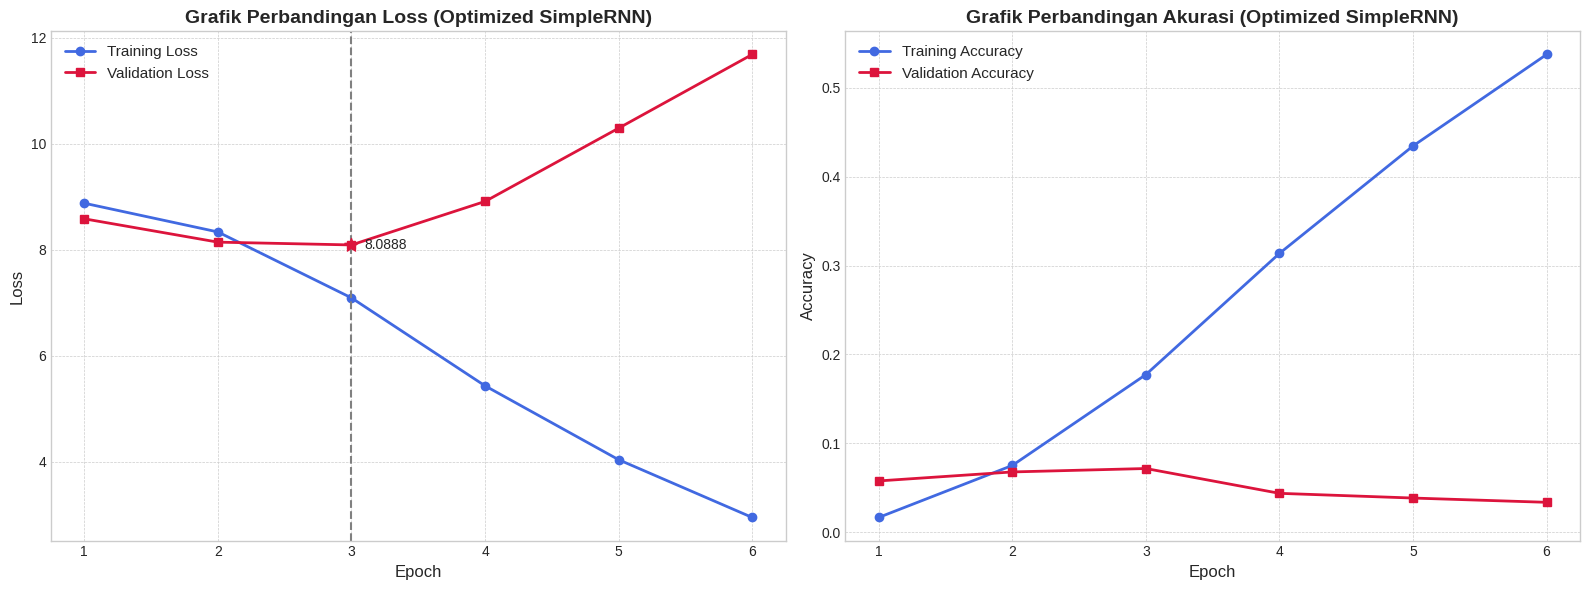

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. Masukkan data dari log training Anda ---
# Data ini diambil langsung dari output training model Optimized SimpleRNN
data = {
    'epoch': [1, 2, 3, 4, 5, 6],
    'loss': [8.8766, 8.3340, 7.0895, 5.4291, 4.0340, 2.9439],
    'start_pointer_accuracy': [0.0150, 0.0753, 0.1680, 0.2980, 0.4220, 0.5379],
    'end_pointer_accuracy': [0.0185, 0.0751, 0.1867, 0.3292, 0.4468, 0.5366],
    'val_loss': [8.5821, 8.1417, 8.0888, 8.9101, 10.2933, 11.6848],
    'val_start_pointer_accuracy': [0.0559, 0.0761, 0.0655, 0.0443, 0.0347, 0.0376],
    'val_end_pointer_accuracy': [0.0597, 0.0597, 0.0780, 0.0434, 0.0424, 0.0299]
}

# Buat DataFrame untuk kemudahan
df = pd.DataFrame(data)

# Hitung rata-rata akurasi untuk training dan validation
df['avg_accuracy'] = df[['start_pointer_accuracy', 'end_pointer_accuracy']].mean(axis=1)
df['avg_val_accuracy'] = df[['val_start_pointer_accuracy', 'val_end_pointer_accuracy']].mean(axis=1)


# --- 2. Membuat Plot untuk Loss dan Akurasi Berdampingan ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # 1 baris, 2 kolom

# Plot untuk Loss (subplot pertama)
axes[0].plot(df['epoch'], df['loss'], 'o-', label='Training Loss', color='royalblue', linewidth=2)
axes[0].plot(df['epoch'], df['val_loss'], 's-', label='Validation Loss', color='crimson', linewidth=2)
axes[0].set_title('Grafik Perbandingan Loss (Optimized SimpleRNN)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_xticks(df['epoch'])
axes[0].legend(fontsize=11)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Menandai titik loss validasi terendah pada subplot pertama
best_epoch = df['val_loss'].idxmin() + 1
min_val_loss = df['val_loss'].min()
axes[0].axvline(x=best_epoch, color='grey', linestyle='--', label=f'Best Epoch: {best_epoch}')
axes[0].scatter(best_epoch, min_val_loss, s=100, color='crimson', zorder=5, marker='*')
axes[0].text(best_epoch + 0.1, min_val_loss, f'{min_val_loss:.4f}', verticalalignment='center')


# Plot untuk Akurasi (subplot kedua)
axes[1].plot(df['epoch'], df['avg_accuracy'], 'o-', label='Training Accuracy', color='royalblue', linewidth=2)
axes[1].plot(df['epoch'], df['avg_val_accuracy'], 's-', label='Validation Accuracy', color='crimson', linewidth=2)
axes[1].set_title('Grafik Perbandingan Akurasi (Optimized SimpleRNN)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_xticks(df['epoch'])
axes[1].legend(fontsize=11)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tight_layout() # Menyesuaikan tata letak agar tidak tumpang tindih
plt.show()